# CARREGAR A BASE DE DADOS (ARQUIVOS NPY)

In [ ]:
## NESTE MODELO AS CLASSES FORAM DETERMINADAS EM RANGES NÃO UNIFORMES PORÉM EM QUANTIDADES UNIFORMES

                                               image  clusters
0  [[[0.3764705882352941, 0.42745098039215684, 0....         2
1  [[[0.19607843137254902, 0.24313725490196078, 0...         2
2  [[[0.3568627450980392, 0.38823529411764707, 0....         2
3  [[[0.28627450980392155, 0.34509803921568627, 0...         2
4  [[[0.2823529411764706, 0.30980392156862746, 0....         2


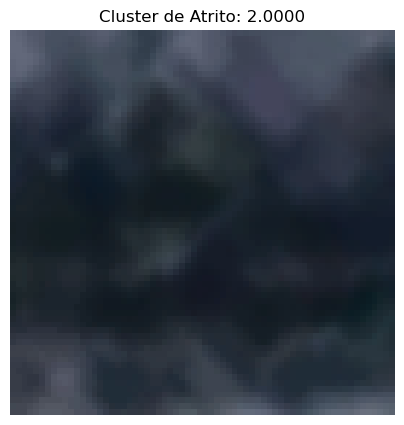

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para os arquivos .npy
images_file_path = r'C:\Users\silve\TESE\images_by_cluster.npy'  # Atualize com o caminho correto do seu arquivo
coefs_file_path = r'C:\Users\silve\TESE\clusters.npy'  # Atualize com o caminho correto do seu arquivo

# Carregar os arrays numpy dos arquivos .npy
images_array = np.load(images_file_path, allow_pickle=True)
coefs_array = np.load(coefs_file_path, allow_pickle=True)

# Reconstruir o DataFrame
df_images = pd.DataFrame({
    'image': list(images_array),  # Converter o array de imagens para uma lista de arrays
    'clusters': coefs_array
})

# Exibir as primeiras linhas do DataFrame para confirmar a estrutura
print(df_images.head())

# Função para exibir uma imagem do DataFrame e seu coeficiente
def display_image_and_atrito(df, index):
    # Verificar se o índice é válido
    if index < 0 or index >= len(df):
        print("Índice fora do intervalo.")
        return

    # Acessar a imagem e o coeficiente
    image_array = df.at[index, 'image']
    atrito = df.at[index, 'clusters']

    # Configurar a figura
    plt.figure(figsize=(5, 5))

    # Exibir a imagem
    plt.imshow(image_array)
    plt.axis('off')  # Desligar os eixos para uma visualização mais clara

    # Exibir o coeficiente de atrito como título
    plt.title(f'Cluster de Atrito: {atrito:.4f}', fontsize=12)

    # Mostrar a figura
    plt.show()

# Exemplo de uso da função para exibir a imagem no índice 0 e seu coeficiente
display_image_and_atrito(df_images, 5)


# CRIAÇÃO DOS GRUPOS DE TREINO, VALIDAÇÃO E TESTE

In [4]:
from sklearn.model_selection import train_test_split

# Dividir o DataFrame em conjunto de treino e teste
train_df, test_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Dividir o conjunto de treino para criar o conjunto de validação
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Tamanho do conjunto de treino: {len(train_df)}')
print(f'Tamanho do conjunto de validação: {len(val_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

# Função para preparar os dados
def prepare_data(df):
    """Extrai imagens e atrito do DataFrame e os converte em arrays numpy."""
    images = np.array(list(df['image']))  # Listar e converter para array numpy
    atrito = np.array(df['clusters'])
    return images, atrito

# Preparar os dados para treino, validação e teste
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

print(f'Forma das imagens de treino: {X_train.shape}')
print(f'Forma dos coeficientes de treino: {y_train.shape}')
print(f'Forma das imagens de validação: {X_val.shape}')
print(f'Forma dos coeficientes de validação: {y_val.shape}')
print(f'Forma das imagens de teste: {X_test.shape}')
print(f'Forma dos coeficientes de teste: {y_test.shape}')

Tamanho do conjunto de treino: 19857
Tamanho do conjunto de validação: 6619
Tamanho do conjunto de teste: 6620
Forma das imagens de treino: (19857, 66, 66, 3)
Forma dos coeficientes de treino: (19857,)
Forma das imagens de validação: (6619, 66, 66, 3)
Forma dos coeficientes de validação: (6619,)
Forma das imagens de teste: (6620, 66, 66, 3)
Forma dos coeficientes de teste: (6620,)


# PROCESSAMENTO DO MODELO

## OTIMIZAÇÃO DOS HIPERPARÂMETROS

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras_tuner import RandomSearch
import numpy as np

# Função para resetar os parâmetros do Keras a cada rodada
def reset_keras():
    K.clear_session()

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=16),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.1)))
    # Adicionando outra camada densa opcional
    if hp.Boolean('extra_dense_layer'):
        model.add(Dense(units=hp.Int('extra_dense_units', min_value=32, max_value=256, step=16),
                        activation='relu'))
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Certifique-se de chamar reset_keras() antes de criar uma nova instância do modelo
reset_keras()
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1
)

tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

# Após a busca, limpe novamente
reset_keras()


Trial 10 Complete [00h 14m 33s]
val_accuracy: 0.31273606419563293

Best val_accuracy So Far: 0.36591631174087524
Total elapsed time: 02h 15m 12s


In [19]:
# Após a busca, limpe novamente
reset_keras()

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=16,  # Número de variações de hiperparâmetros a testar
                     executions_per_trial=1,  # Número de modelos a construir para cada variação de hiperparâmetros
                     directory='keras_tuner_dir',
                     project_name='atrito_classification')

tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Reloading Tuner from keras_tuner_dir\atrito_classification\tuner0.json


In [21]:
import matplotlib.pyplot as plt

def plot_tuner_results(tuner):
    results = tuner.results_summary(num_trials=3)  # Exibe um resumo dos 3 melhores testes
    trials = tuner.oracle.get_best_trials(num_trials=3)

    for trial in trials:
        hp = trial.hyperparameters.values
        print(f"Learning Rate: {hp['learning_rate']}, Conv_1_Filter: {hp['conv_1_filter']}, Dense_Units: {hp['dense_units']}")
        # Adicione mais parâmetros conforme necessário

    # Plotar métricas pode requerer acesso a informações mais detalhadas do histórico de cada trial
    # Isso pode ser específico à sua implementação e como você registra os resultados durante o treinamento

plot_tuner_results(tuner)


Results summary
Results in .\untitled_project
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
conv_1_filter: 256
conv_1_kernel: 3
conv_2_filter: 80
conv_2_kernel: 3
dense_units: 112
dropout: 0.0
extra_dense_layer: True
learning_rate: 0.0010770030890731043
extra_dense_units: 176
Score: 0.36591631174087524

Trial 07 summary
Hyperparameters:
conv_1_filter: 224
conv_1_kernel: 3
conv_2_filter: 80
conv_2_kernel: 3
dense_units: 208
dropout: 0.0
extra_dense_layer: True
learning_rate: 0.0012998763075827591
extra_dense_units: 144
Score: 0.3541320562362671

Trial 03 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 3
dense_units: 128
dropout: 0.2
extra_dense_layer: False
learning_rate: 0.0017349297789334736
extra_dense_units: 160
Score: 0.3218008875846863
Learning Rate: 0.0010770030890731043, Conv_1_Filter: 256, Dense_Units: 112
Learning Rate: 0.0012998763075827591, Conv_1_Filter: 224, Dense_Units:

## RODANDO O MODELO DE ACORDO COM OS HIPERPARÂMETROS OTIMIZADOS

In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)

# Treinar o melhor modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


Epoch 1/100
621/621 [==============================] - 108s 173ms/step - loss: 2.0486 - accuracy: 0.2786 - val_loss: 1.4037 - val_accuracy: 0.2750
Epoch 2/100
621/621 [==============================] - 104s 167ms/step - loss: 1.3750 - accuracy: 0.3091 - val_loss: 1.3667 - val_accuracy: 0.3235
Epoch 3/100
621/621 [==============================] - 104s 168ms/step - loss: 1.3640 - accuracy: 0.3195 - val_loss: 1.3610 - val_accuracy: 0.3147
Epoch 4/100
621/621 [==============================] - 104s 167ms/step - loss: 1.3541 - accuracy: 0.3308 - val_loss: 1.3711 - val_accuracy: 0.3120
Epoch 5/100
621/621 [==============================] - 112s 181ms/step - loss: 1.3465 - accuracy: 0.3381 - val_loss: 1.3614 - val_accuracy: 0.3093
Epoch 6/100
621/621 [==============================] - 109s 176ms/step - loss: 1.3446 - accuracy: 0.3417 - val_loss: 1.4119 - val_accuracy: 0.3111
Epoch 7/100
621/621 [==============================] - 105s 169ms/step - loss: 1.3405 - accuracy: 0.3445 - val_loss: 1

621/621 [==============================] - 109s 175ms/step - loss: 1.0836 - accuracy: 0.5187 - val_loss: 1.4557 - val_accuracy: 0.3730
Epoch 57/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0765 - accuracy: 0.5254 - val_loss: 1.3955 - val_accuracy: 0.3854
Epoch 58/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0656 - accuracy: 0.5281 - val_loss: 1.4100 - val_accuracy: 0.3886
Epoch 59/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0619 - accuracy: 0.5302 - val_loss: 1.3893 - val_accuracy: 0.3967
Epoch 60/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0598 - accuracy: 0.5296 - val_loss: 1.6102 - val_accuracy: 0.3337
Epoch 61/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0476 - accuracy: 0.5443 - val_loss: 1.4852 - val_accuracy: 0.3777
Epoch 62/100
621/621 [==============================] - 109s 175ms/step - loss: 1.0482 - accuracy: 0.5467 - val_loss: 1.4200 

## INDICADORES DE PERFORMANCE DO MODELO

### PARÂMETROS NUMÉRICOS NO TESTE (PERDA, ACURÁCIA, PRECISÃO, RECALL E F1)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Avaliar o modelo no conjunto de validação
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)

# Previsões do modelo
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verificar se y_val é categórico e converter para classes se necessário
if y_val.ndim > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Acurácia
accuracy = accuracy_score(y_true, y_pred_classes)

# Precisão
precision = precision_score(y_true, y_pred_classes, average='macro')

# Recall
recall = recall_score(y_true, y_pred_classes, average='macro')

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average='macro')

# Imprimir os resultados
print(f"Perda no Teste: {test_loss}")
print(f"Acurácia no Teste: {test_acc}")
print("Matriz de Confusão:", conf_matrix, sep="\n")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"Pontuação F1: {f1}")


207/207 - 9s - loss: 2.0417 - accuracy: 0.3649 - 9s/epoch - 44ms/step
207/207 [==============================] - 9s 45ms/step
Perda no Teste: 2.041731595993042
Acurácia no Teste: 0.3648587465286255
Matriz de Confusão:
[[568 540 298 222]
 [375 743 400 294]
 [295 524 582 350]
 [214 333 359 522]]
Precisão: 0.36738902404682994
Recall: 0.36421655344498866
Pontuação F1: 0.36473619570055005


### CURVA DE APRENDIZADO PERDA E ACURÁCIA

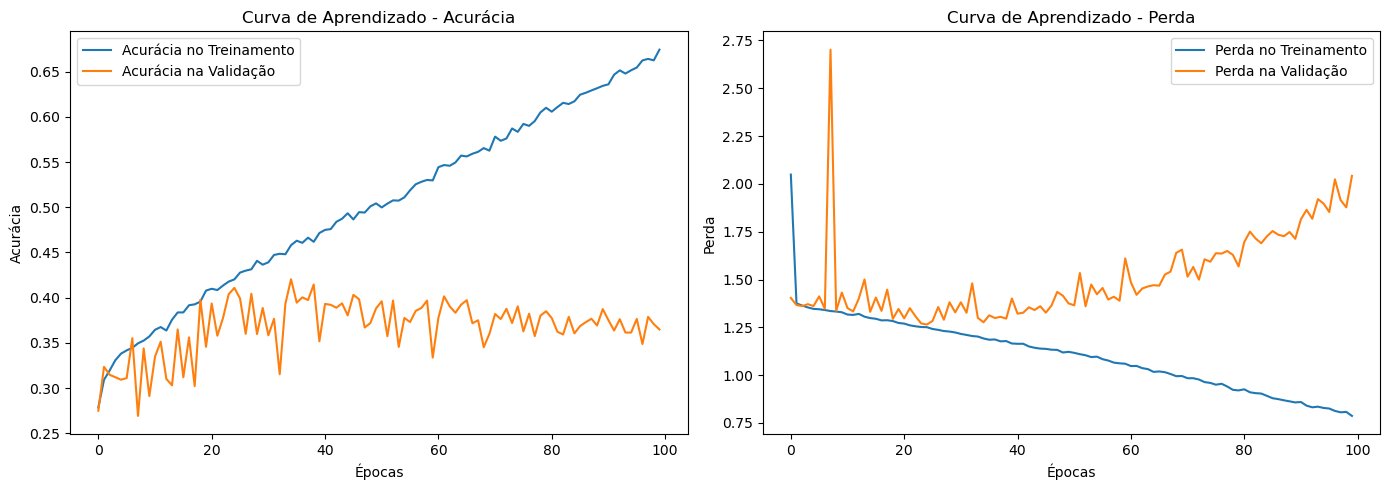

In [26]:
import matplotlib.pyplot as plt

# Plotando as curvas de aprendizado
plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Curva de Aprendizado - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


### MATRIZ DE CONFUSÃO

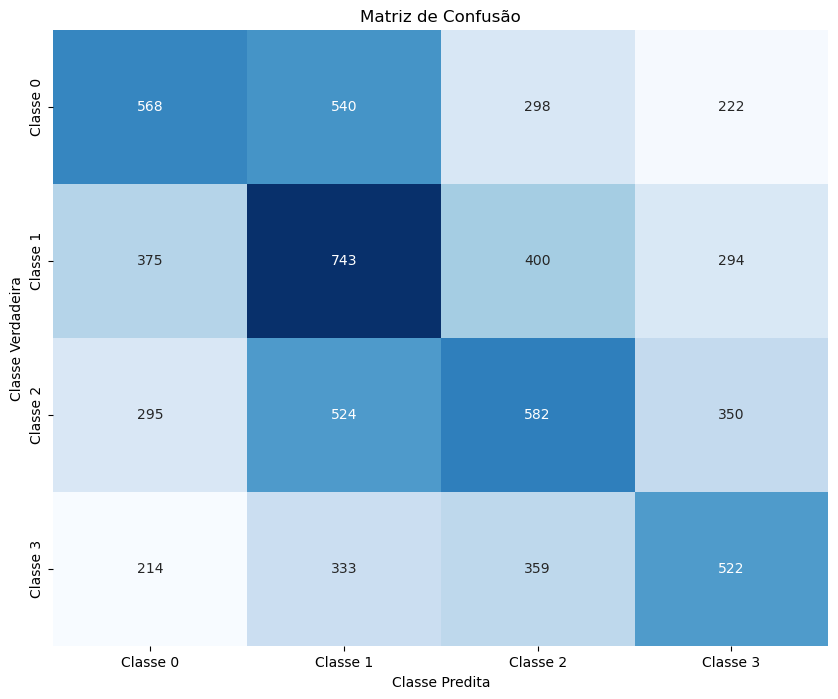

In [28]:
# MATRIZ DE CONFUSÃO

# Primeiro, instale as bibliotecas necessárias se ainda não estiverem instaladas:
# !pip install matplotlib seaborn numpy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Insira seus dados de Matriz de Confusão aqui
confusion_mtx = conf_matrix

# Etiquetas para os eixos
axis_labels = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3']

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Criando o heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

# Adicionando o título e os rótulos dos eixos
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')

# Mostrando o gráfico
plt.show()


207/207 [==============================] - 9s 43ms/step


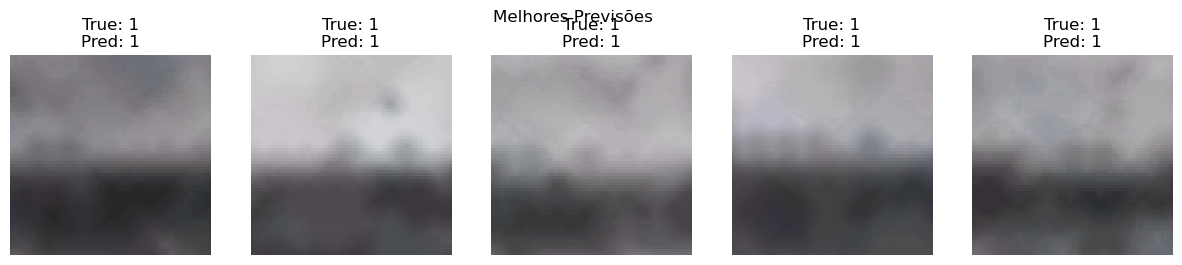

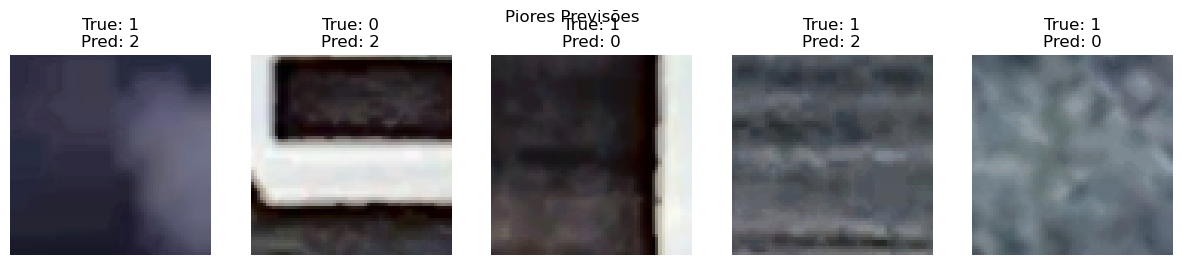

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Supondo que 'model' seja o seu modelo treinado e 'X_test' o seu conjunto de testes
# e 'y_test' os rótulos verdadeiros.
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calcular as diferenças de confiança nas previsões corretas e incorretas
correct_confidences = np.max(y_pred_probs[y_test == y_pred_classes], axis=1)
incorrect_confidences = np.max(y_pred_probs[y_test != y_pred_classes], axis=1)

# Obter os índices das previsões corretas e incorretas
correct_indices = np.where(y_test == y_pred_classes)[0]
incorrect_indices = np.where(y_test != y_pred_classes)[0]

# Obter os índices dos maiores valores de confiança para as previsões corretas e incorretas
best_correct = np.argsort(correct_confidences)[-5:]
worst_incorrect = np.argsort(incorrect_confidences)[-5:]

# Função para plotar imagens
def plot_prediction_images(indices, images, true_labels, pred_labels, title):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray') # Ajuste o cmap se as imagens não forem em escala de cinza
        plt.title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plotar as cinco melhores previsões
best_indices = correct_indices[best_correct]
plot_prediction_images(best_indices, X_test, y_test, y_pred_classes, "Melhores Previsões")

# Plotar as cinco piores previsões
worst_indices = incorrect_indices[worst_incorrect]
plot_prediction_images(worst_indices, X_test, y_test, y_pred_classes, "Piores Previsões")


## SALVANDO O MODELO

In [27]:
# Salvar o modelo no formato HDF5
model.save('meu_modelo_2.h5')

# Salvar o modelo no formato SavedModel
model.save('meu_modelo_2')


C:\Users\silve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: meu_modelo_2\assets


INFO:tensorflow:Assets written to: meu_modelo_2\assets


207/207 [==============================] - 10s 48ms/step
              precision    recall  f1-score   support

           0       0.38      0.33      0.36      1662
           1       0.35      0.39      0.36      1848
           2       0.36      0.37      0.36      1719
           3       0.37      0.35      0.36      1391

    accuracy                           0.36      6620
   macro avg       0.36      0.36      0.36      6620
weighted avg       0.36      0.36      0.36      6620



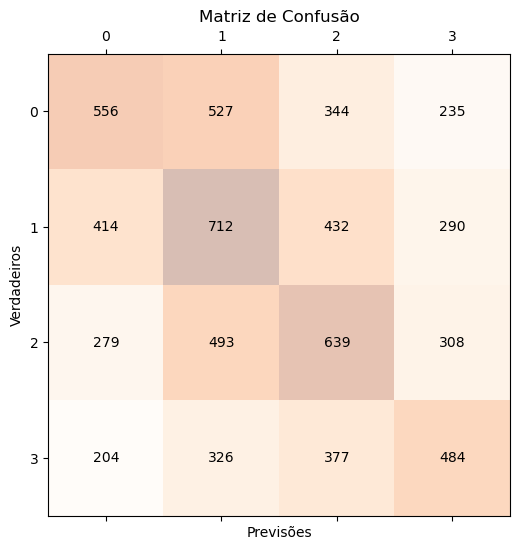

In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Carregar o modelo treinado
model = load_model('meu_modelo_2.h5')

# Supondo que 'X_test' e 'y_test' estejam carregados e preparados para uso
# Substitua 'path_to_your_model.h5' pelo caminho correto do seu arquivo .h5

# Previsões
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Métricas de desempenho
print(classification_report(y_test, y_pred_classes))
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotar a matriz de confusão
fig, ax = plt.subplots(figsize=(8, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')
plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

# Plotar as imagens das melhores e piores previsões conforme a lógica explicada anteriormente
# (Você precisará implementar a função plot_prediction_images e calcular best_indices e worst_indices)
